### Importing required libraries

In [1]:
import torch
import numpy as np
from torch import nn
import pandas as pd
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

### Importing the data

For performing the task of named entity recognition, the data is coming from ConLL 2003

In [2]:
from datasets import load_dataset

conllu_train= load_dataset("conll2003", split="train")

To make this easier to visulaize, lets store it in a pandas dataframe

In [3]:
df_train = conllu_train.to_pandas()
df_train.head(3)

,id,tokens,pos_tags,chunk_tags,ner_tags
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[3, 0, 7, 0, 0, 0, 7, 0, 0]"
1,1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[1, 2]"
2,2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[5, 0]"


In [4]:
df_train.shape

(14041, 5)

### Cleaning the data

Now, for this particular task, I dont want to delve too deep into the differences Before and Inside tags. Instead, we will convert those to just one tag. So, on reducing the number of labels, we get:

In [5]:
ner_tags = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

new_mapping = {0: 'O', 1: 'PER', 2: 'PER', 3: 'ORG', 4: 'ORG', 5: 'LOC', 6: 'LOC', 7: 'MISC', 8: 'MISC'}
df_train['ner_tags'] = df_train['ner_tags'].apply(lambda tags: [new_mapping[tag] for tag in tags])

In [6]:
labels = ['O', 'PER', 'ORG', 'LOC', 'MISC']

Also, there are certain rows of this dataframe which contain just one token. As this does not benefit the training of a CRF, which is a linear chain, and looks for past context, I have decided to remove these cases from the training set

In [7]:
df_train = df_train[df_train['tokens'].apply(len) >= 2]
df_train.shape

(13862, 5)

In [8]:
df_train.head(3)

,id,tokens,pos_tags,chunk_tags,ner_tags
0,0,"[EU, rejects, German, call, to, boycott, Briti...","[22, 42, 16, 21, 35, 37, 16, 21, 7]","[11, 21, 11, 12, 21, 22, 11, 12, 0]","[ORG, O, MISC, O, O, O, MISC, O, O]"
1,1,"[Peter, Blackburn]","[22, 22]","[11, 12]","[PER, PER]"
2,2,"[BRUSSELS, 1996-08-22]","[22, 11]","[11, 12]","[LOC, O]"


We can see from the above output that the data is more or less how we want it for now

### Function to featurize and get the numerator score

Given the CRF formula, let us write a function to calculate the numerator of this. As this comes in handy when performing he Viterbi algorithm, it is an important function to have. 

In [9]:
def num_score(tags, tokens, weights):
    if len(tags) != len(tokens):
        return "Check size of input lists"
    word_features = []
    sum_features = []
    for i, token in enumerate(tokens):
        #Create the 2 Emission features
        word_features.append(int(token[0].isupper()))
        word_features.append(int(any(char.isdigit() for char in token)))
        #Checking the starting tag
        for label in labels:
            if i ==0 and tags[i] == label:
                word_features.append(1)
            else:
                word_features.append(0)
        #Transition features
        for prev in labels:
            for curr in labels:
                if i == 0:
                    word_features.append(0)
                elif tags[i-1] == prev and tags[i] == curr:
                    word_features.append(1)
                else:
                    word_features.append(0)    
        # Now adding this across all the words in the sentence
        if sum_features == []:
            sum_features = word_features
        else:
            sum_features = [x + y for x, y in zip(word_features, sum_features)]
        word_features = []
    sent_tensor = torch.FloatTensor(sum_features)
    dot_product = torch.dot(sent_tensor, weights)
    return torch.exp(dot_product)

Before we can test this out on some random examples, we must first define our weights tensor. 

We have 2 Emission features, and 30 Transition features. So that means overall:

In [10]:
num_features = 32

In [11]:
weights = torch.rand(num_features) -.5 #Creates a weights vector of size 'num_features', ranging from -0.5 to 0.5
weights.requires_grad = True
print(weights)

tensor([ 0.1677,  0.4354,  0.2489,  0.1268, -0.0569, -0.2764,  0.2271, -0.1528,
         0.3983, -0.0735,  0.4706,  0.4580,  0.3593,  0.3376, -0.4687,  0.0077,
        -0.4591,  0.1546, -0.1113,  0.3441,  0.0794,  0.1047, -0.1872, -0.0880,
        -0.0575, -0.2717,  0.1433, -0.1312,  0.2767, -0.2133,  0.1053,  0.0806],
       requires_grad=True)


Now to test the num_score funtion

In [12]:
num_score(["PER", "O", "O", "O", "LOC"], ["Laura", "was", "born", "in", "Slovenia"], weights)

tensor(2.6817, grad_fn=<ExpBackward0>)

In [13]:
num_score(["PER", "O", "O"], ["Laura", "was", "born"], weights)

tensor(1.6503, grad_fn=<ExpBackward0>)

In [14]:
num_score(["MISC", "MISC", "MISC"], ["Laura", "was", "born"], weights)

tensor(1.7438, grad_fn=<ExpBackward0>)

As these weights are still untrained, the score is random. But the function is working as desired right now

### Viterbi Algorithm

In the Eisenstein textbook, the suggested method to get the best label was to keep all the scores in a lookup matrix called v and use backpointers to retrace the top label.
My aporach was a little different. I would store the top tags at each stage and keep iterating through the words until the end. This may have a slightly higher space complexity, as we need a few more temporary arrays to hold the information, but the time complexity (which is the big advantage of using Viterbi) is not compromised.

In [15]:
def viterbi(tokens, weights):  
    best_taglist_so_far = [[label] for label in labels]
    best_scorelist_so_far = []
    for token_idx in range(1, len(tokens)):
        best_curr_taglist = []
        best_curr_scorelist = []
        for curr_label in labels:
            best_curr_score = torch.tensor(-float('inf'))
            best_curr_tag = []
            for prev in best_taglist_so_far:
                curr_taglist = prev.copy()
                curr_taglist.append(curr_label)
                curr_tokenlist = tokens[:token_idx+1]          
                if num_score(curr_taglist, curr_tokenlist, weights) > best_curr_score:
                    best_curr_score = num_score(curr_taglist, curr_tokenlist, weights)
                    best_curr_tag = curr_taglist.copy()
            best_curr_taglist.append(best_curr_tag)
            best_curr_scorelist.append(best_curr_score)
        best_taglist_so_far = best_curr_taglist.copy()
        best_scorelist_so_far = best_curr_scorelist.copy()
    highest_score = torch.tensor(-float('inf'))
    for idx in range(len(best_scorelist_so_far)):
        if best_scorelist_so_far[idx] > highest_score:
            highest_score = best_scorelist_so_far[idx]
            final_tag = best_taglist_so_far[idx]
    return final_tag

In [16]:
start = timer()
print(viterbi(["Laura", "was", "born", "in", "Slovenia"], weights))
print(f"Executed in {timer() - start} seconds") 

['O', 'PER', 'PER', 'O', 'LOC']
Executed in 0.014128200011327863 seconds


Again, as these are unlearned weights, the predicted tags are random. Lets try the same sentence with some other weights

In [17]:
weights2 = torch.rand(num_features) -.5
weights3 = torch.rand(num_features) -.5

In [18]:
start = timer()
print(viterbi(["Laura", "was", "born", "in", "Slovenia"], weights2))
print(f"Executed in {timer() - start} seconds") 

['MISC', 'ORG', 'O', 'ORG', 'O']
Executed in 0.01268760021775961 seconds


In [19]:
start = timer()
print(viterbi(["Laura", "was", "born", "in", "Slovenia"], weights3))
print(f"Executed in {timer() - start} seconds") 

['ORG', 'MISC', 'ORG', 'PER', 'MISC']
Executed in 0.013858600053936243 seconds


So, from here we can see that depending on the weights the predicted tags change. This shows us that the viterbi algorithm code is working

### Building a Baseline Model

The idea for a baseline model is to just predict the most consistently appearing tag for every word, and we can see how this scores. First, we must find which tag is the most frequently appearing. (Note: Code for below done with reference from stack overflow for seaborn syntax)

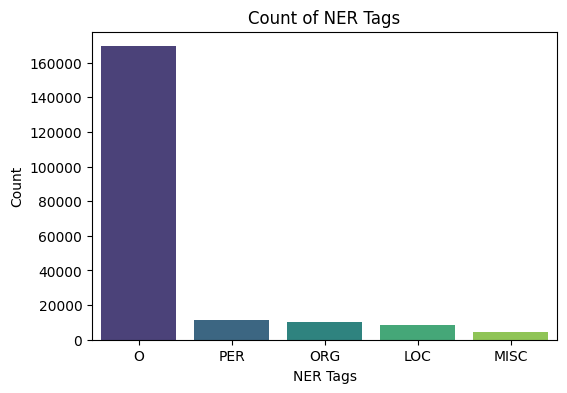

In [20]:
all_tags = [tag for sublist in df_train['ner_tags'] for tag in sublist]
tag_counts = pd.Series(all_tags).value_counts()
tag_counts_df = pd.DataFrame({'Tag': tag_counts.index, 'Count': tag_counts.values})

plt.figure(figsize=(6, 4))
sns.barplot(x='Tag', y='Count', data=tag_counts_df, palette='viridis')
plt.xlabel('NER Tags')
plt.ylabel('Count')
plt.title('Count of NER Tags')
plt.show()

So, it is unsurprisingly very clear that the 'Other' tag is the most common tag. So, let us build a baseline model to predict every word as 'O'

In [21]:
def baseline_pred(tokens):
    return ['O']*len(tokens)

In [22]:
baseline_pred(['John', 'in', 'California'])

['O', 'O', 'O']

Now, let's test this out on some dev data, and see how much we score

In [23]:
conllu_val= load_dataset("conll2003", split="validation")
df_val = conllu_val.to_pandas()
df_val['ner_tags'] = df_val['ner_tags'].apply(lambda tags: [new_mapping[tag] for tag in tags])

In [24]:
def get_acc(true_labels, pred_labels):
    if len(true_labels) != len(pred_labels):
        return 0
    count = 0
    for i in range(len(true_labels)):
        if true_labels[i] == pred_labels[i]:
            count+=1
    return count/len(true_labels)

In [25]:
get_acc(df_val.iloc[0]['ner_tags'], baseline_pred(df_val.iloc[0]['tokens']))

0.9090909090909091

In [26]:
df_val.iloc[0]['ner_tags']

['O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

We can see that 10 out of 11 of the above tags are 'Other' and so the accuracy for this sentence makes sense

Now, one way to calculate overall accuracy is to go through the whole val and find each label-based accuracy score and find the mean across the dataset

In [27]:
acc_list = []
for x in range(df_val.shape[0]):
    acc_list.append(get_acc(df_val.iloc[x]['ner_tags'], baseline_pred(df_val.iloc[x]['tokens'])))
acc_tensor = torch.tensor(acc_list)
print("Baseline accuracy is:", acc_tensor.mean().item())

Baseline accuracy is: 0.7714390158653259


### Loss and training

This is the part that I found tricky, and could not complete to the end. According to the Eisenstein book, we need to calculate the negative log probability, given the numerator (say exp(s)) and the normalization function Z(x) as the denominator.

I found it too complicated to calculate this loss, so I decided to define my own. This is far simpler in theory, where it just checks the label-wise accuracy of the prediction versus the actual tags.

So if we predict ["O", "PER", "LOC"] and the actual tags are ["PER", "LOC", "LOC"], then we got only 1 label correct (the last one), and so the loss will be 2/3 or 0.667

In [28]:
def get_loss(pred_tags, actual_tags):
    correct_preds = 0
    for i in range(len(pred_tags)):
        if pred_tags[i] == actual_tags[i]:
            correct_preds +=1
    return torch.tensor(1 - (correct_preds/len(pred_tags)), requires_grad = True)

However, this most probably will not work. The reason being, pytorch will not be able to calculate the gradient of the loss with respect to the weights vector, as after the viterbi, we are not using any direct score which is linked to the weight, but rather taking the output list and computing a loss score on that.

So while I am aware the training wont work, let us build the model anyways 

In [29]:
class Model(nn.Module):
    def __init__(self, weights):
        super(Model, self).__init__()
        self.weights = nn.Parameter(weights)

    def forward(self, tokens):
        pred_tags = viterbi(tokens, self.weights)
        return pred_tags

In [30]:
model = Model(weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [31]:
for epoch in range(100):
    #forward pass
    pred_tags = model.forward(df_train.iloc[0]['tokens'])
    l = get_loss((df_train.iloc[0]['ner_tags']), pred_tags)
    
    #backward pass
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch %10 == 0:
        print(f'Loss at Epoch {epoch} = {l}')

Loss at Epoch 0 = 0.6666666865348816
Loss at Epoch 10 = 0.6666666865348816
Loss at Epoch 20 = 0.6666666865348816
Loss at Epoch 30 = 0.6666666865348816
Loss at Epoch 40 = 0.6666666865348816
Loss at Epoch 50 = 0.6666666865348816
Loss at Epoch 60 = 0.6666666865348816
Loss at Epoch 70 = 0.6666666865348816
Loss at Epoch 80 = 0.6666666865348816
Loss at Epoch 90 = 0.6666666865348816
